<a href="https://colab.research.google.com/github/Matammanjunath/Matammanjunath/blob/main/20220429_ArrayIVfrmStringIVs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In this code, import string I-Vs computed at close timestamps and obtain array I-V
# This is good when sky is stable or consider clear sky data only

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib.patches import Polygon
import natsort as ns
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import matplotlib.dates as matdates
import pandas as pd
import numpy as np
import itertools
import statistics as stat
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from google.colab import files
!cp /content/drive/MyDrive/00Python_Template_Files/plot_templates_manju.py .
import plot_templates_manju 
!cp /content/drive/MyDrive/00Python_Template_Files/ivcurves_data_extraction_functions.py .
import ivcurves_data_extraction_functions
!cp /content/drive/MyDrive/00Python_Template_Files/physics_utils.py .
import physics_utils
!cp /content/drive/MyDrive/00Python_Template_Files/preprocess.py .
import preprocess


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#plot_templates_manju.oscilloscope_plot
# Functions
def high_res_dataframe(df, data_fre='1s'):
    """"df has timestamp index in '%Y-%m-%d %H:%M:%S' format, float cloumns. 
    The function initially creates an ideal, appends this to main df and this creates nans. Finally, NaNs are filled by interpolation"""
    high_residx = pd.date_range(df.index.strftime(
        '%Y-%m-%d %H:%M:%S')[0], df.index.strftime('%Y-%m-%d %H:%M:%S')[-1], freq='1s')
    df = df.reindex(high_residx)
    df.interpolate(method='index', inplace=True)
    return df

    def stable_sky_filter(df,poa_col_name='POA',stable_poa_seconds=60,stable_poa_wm2=15):
        """    
        Parameters
        ----------
        df : dataframe
            DESCRIPTION. Dataframe with index timestamp, dtype='datetime64[ns]'
        poa_col_name : string, optional
            DESCRIPTION. The default is 'POA'. It denotes name of the 
            plane of array irradiance or irradiance column.
        stable_poa_seconds : int, optional
            DESCRIPTION. The default is 1. Checking last 60s duration.
        stable_poa_wm2 : int, optional
            DESCRIPTION. The default is 15. Choose and check if change in the irradiance < 15 W/m2. 
            Value 15 W/m2/1 min was choosen after observing clear sky day profiles which changed not
            more than 15 W/m2 every minute.
    
        Returns
        -------
        df : TYPE
            DESCRIPTION. Returning the original dataframe after dropping unstable sky rows
        """
        df['index']=df.index
        df.reset_index(inplace=True,drop=True)
        samp_dur = np.nanmax(df['index'].diff(periods=1).dt.total_seconds().unique())
        samp = int(stable_poa_seconds/samp_dur)
        df['POA_dif'] = df['POA'].diff(periods=samp)
        df['unskystable?'] = df['POA_dif'].abs().ge(stable_poa_wm2)
        ## Check if unstable_sky is true or change in POA in last 1 min > 15 W/m2 and drop all rows in between
        if len(df[df['unskystable?']])>1:
            stable_idx = pd.concat(df.loc[i-samp:i:1] for i,r in df.iterrows() if r['unskystable?']==True).drop_duplicates(keep='first').index 
            df = df[~df.index.isin(stable_idx)].set_index('index')
        # drop the columns created in this function
        drop_cols = ['POA_dif','unskystable?']
        df.drop(drop_cols, axis=1, inplace=True)
        return df


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Data left after the POA filter is 42%


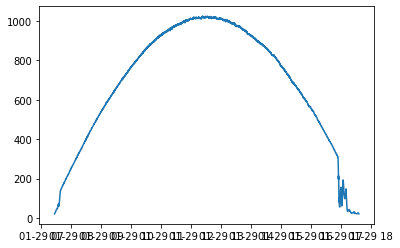

Index(['8157_S1groupchannel_name', '8157_S1current', '8157_S1voltage',
       '8157_S1irradiance', '8157_S1timestamp', '8157_S1t_dif',
       '8157_S1POA (W/m2)', '8157_S1power', '8157_S2groupchannel_name',
       '8157_S2current', '8157_S2voltage', '8157_S2irradiance',
       '8157_S2timestamp', '8157_S2t_dif', '8157_S2POA (W/m2)',
       '8157_S2power'],
      dtype='object')


/content/preprocess.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  procIs = np.array(procIs)
/content/preprocess.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  procVs = np.array(procVs)


In [3]:
daylbl = '20190129'
# Import strings I-V data and produce array I-V curve
#### Import files 
fold_loc = '/content/drive/MyDrive/20220429_ArrayIVfrmStringIVs'
# Relevant file name
file_name = '/8157_Pordis_IVdata_%s'%(daylbl)
ivdf = pd.read_csv(fold_loc+'%s.csv'%(file_name))
# test times
ivdf['datetime'] = pd.to_datetime(ivdf['datetime'],format='%Y-%m-%d %H:%M:%S')
# Set datetime as index
ivdf.set_index('datetime',inplace=True,drop=True)
ivdf['timestamp'] = ivdf.index
# compute time difference between the scans or rows
ivdf['t_dif'] = ivdf['timestamp'].diff(periods=1).dt.total_seconds()
# print(ivdf.index)

## poa irradiance data
file_name = '/8157_Pordis_licorPOA_%s'%(daylbl)
poa = pd.read_csv(fold_loc+'%s.csv'%(file_name))
## Demelt the dataframe
poa = poa.pivot(index='measdatetime', columns='modbus_readout_id')['final_value']
col_ids = poa.columns.tolist()

## Import modbus readout ids and labels
mid = pd.read_csv(fold_loc+'/8157_MySql_ModbusReadoutIDs_Manju.csv')
req_labls = mid[mid['modbus_readout_id'].isin(col_ids)]
## Replace dataframe modbus ids with labels
poa.rename(columns=dict(zip(req_labls['modbus_readout_id'],req_labls['channel_name'])),inplace=True)
## drop unwanted columns
# df.drop(df.columns[0],inplace=True,axis=1)
# Set index
poa.index = pd.to_datetime(poa.index,format='%Y-%m-%d %H:%M:%S')
# Rename columns
poa.rename(inplace=True, columns={"Irradiance":"POA (W/m2)",
                                    "R02.C06_Temp":"TM1",
                                    "R02.C01_Temp":"TM6",
                                    "R01.C04_Temp":"TM10",
                                    "R02.C10_Temp":"TM15",
                                    "R01.C13_Temp":"TM20",
                                    "R01.C08_Temp":"TM23",
                                    "S_1_VOLTAGE":"S1Vdc (V)",
                                    "S_1_CURRENT":"S1Idc (A)",
                                    "S_2_VOLTAGE":"S2Vdc (V)",
                                    "S_2_CURRENT":"S2Idc (A)"})
## Filter-1: Drop low POA data
tn = len(poa)
poa = poa[poa['POA (W/m2)']>20]
print("Data left after the POA filter is %d%%"%(len(poa)*100/tn))
plt.plot(poa.index,poa['POA (W/m2)'])
plt.show()
### Append poa data to the ivdf
ivdf = pd.merge_asof(ivdf,poa['POA (W/m2)'],left_index=True,right_index=True,direction='nearest',tolerance=pd.Timedelta('6s'))
# print(ndf['POA (W/m2)'])

# change each cell data to list type
for i in ivdf.index:#range(len(ivdf)):
    vstr, istr = ivcurves_data_extraction_functions.string_to_float(
        ivdf.loc[i, 'voltage']), ivcurves_data_extraction_functions.string_to_float(ivdf.loc[i, 'current'])
    ivdf.at[i, 'voltage'], ivdf.at[i, 'current'] = vstr, istr

# Bring all I-V curves to a common voltage and resolution
ivdf = preprocess.preprocess(ivdf, volt_start=0, volt_resolution=1)

# Check each scan and identify the pairs 
# Time difference between S1 and S2 scans is around 270 sec. 
######## Scanning wise grouping of data
sm_list = []
for name in ivdf.groupchannel_name.unique():      
  sm_list.append(ivdf.loc[ivdf.groupchannel_name == name, :]) # print(len(sm_list))
# print(sm_list)
l = []
s1 = []
for i in range(0,len(sm_list),1):
#        print("%s scanned %d times"%(sm_list[i]['group'][0],len(sm_list[i])))
    if i==0:
        nm = sm_list[i]['groupchannel_name'][0]
        s1=sm_list[i].add_prefix(nm)  ####s1.dtypes, s1.index
        l.append(s1)
    else:             #sm_list[0]
        nm = sm_list[i]['groupchannel_name'][i]
#            sm_list[i].drop(['group','datetime'],inplace=True,axis=1)
        l.append(pd.merge_asof(s1,sm_list[i].add_prefix(nm),left_index=True,right_index=True,
                              direction='nearest',tolerance=pd.Timedelta('5min')))
combdf = pd.concat(l,axis=1) ### 
combdf = combdf.groupby(combdf.columns,axis=1,sort=False).first() #              
print(combdf.columns)
# import natsort as ns
# s = sorted(ns.natsorted([x for x in combdf.columns if x[0] == 'S']))
# m = sorted(ns.natsorted([x for x in combdf.columns if x[0] == 'M']))
# combdf = combdf[s + m]
#     #### total group scans
tgs = len(combdf)
combdf['delT'] = (combdf['8157_S2timestamp'] - combdf['8157_S1timestamp']).dt.total_seconds()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

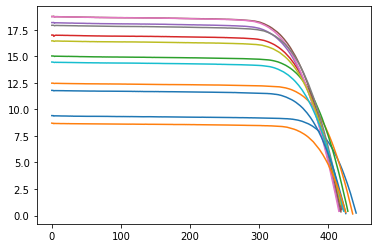

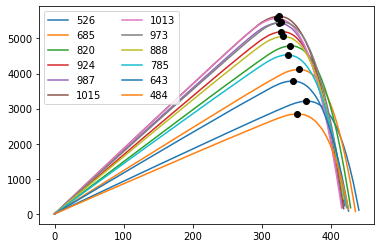

In [4]:
## Filter low irradiance scans
combdf = combdf.loc[combdf['8157_S1POA (W/m2)']>200]
# pd.DataFrame(columns=['voltage','current','power','datetime'],index=n_cond)
combdf['Array current (A)'] = combdf[['8157_S1current','8157_S2current']].apply(lambda x:[sum(x) for x in zip(x[0],x[1])],axis=1)
combdf['Array voltage (V)'] = combdf['8157_S1voltage']
combdf['Array power (W)'] = combdf[['8157_S1current','8157_S2current','Array voltage (V)']].apply(lambda x: [(i+j)*z for i,j,z in zip(x[0],x[1],x[2])],axis=1) # zip(*x)
# Drop the array data points in current or voltage to ensure both of same lenghts
# Minimum number of data points either in array voltage or current samples
combdf['Min.I-V samples'] = combdf[['Array current (A)','Array voltage (V)']].apply(lambda x:min(len(x[0]),len(x[1])),axis=1)
combdf['Array current (A)'] = combdf[['Array current (A)','Min.I-V samples']].apply(lambda x:x[0][:x[1]],axis=1) 
combdf['Array voltage (V)'] = combdf[['Array voltage (V)','Min.I-V samples']].apply(lambda x:x[0][:x[1]],axis=1) 
combdf['Array power (W)'] = combdf[['Array power (W)','Min.I-V samples']].apply(lambda x:x[0][:x[1]],axis=1) 
# Find MPP voltage of the each curve
combdf['Array mpp idx'] = combdf[['Array power (W)','Array voltage (V)']].apply(lambda x: np.argmax(x[0]),axis=1)
combdf['Array Vmpp (V)'] = combdf[['Array power (W)','Array voltage (V)']].apply(lambda x: x[1][np.argmax(x[0])],axis=1)
# print(combdf[['Array mpp idx','Array Vmpp (V)']])
combdf['Array Pmpp (W)'] = combdf[['Array power (W)','Array voltage (V)']].apply(lambda x: np.max(x[0]),axis=1)
# # # plot i-v curves
for i in combdf.index:
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array current (A)'].loc[i])
plt.show()
for i in combdf.index:
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array power (W)'].loc[i],
             label='%d'%(combdf['8157_S1POA (W/m2)'].loc[i]))
    plt.plot(combdf['Array Vmpp (V)'].loc[i],combdf['Array Pmpp (W)'].loc[i],'ko')
plt.legend(loc='best',fontsize=10,ncol=2)
plt.show()

# sns.set(font_scale=1.2)
# sns_plot = sns.relplot(x='Array voltage (V)',
#                 y='Array current (A)',
#                 # y='Array Power (W)',
#                 # y='dP/dV (W/V)',
#               data=combdf, hue='datetime',
#               kind='line')
# # plt.axis([0,430,0,ardf['Array Current (A)'].max()*1.1])
# # plt.axis([270,430,0,ardf['Array Power (W)'].max()*1.1])
# # plt.axis([200,430,ardf['dP/dV (W/V)'].min()*1.1,ardf['dP/dV (W/V)'].max()*1.1])
# temp_name3 = 'ArrayCurves.png'
# # plt.subplots_adjust(left=0.05, right=0.99, top=0.99, bottom=0.05)        
# sns_plot.savefig(temp_name3,bbox_inches='tight',pad_inches=0.1, dpi=250)
# # plt.close()
# plt.show()


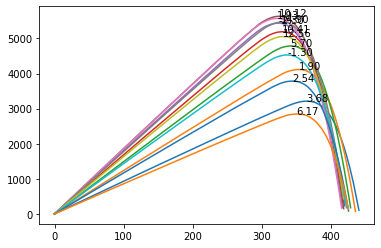

In [5]:
## Filter the I-V curves and drop the untrackable MPPs
## Use gradient approach (d/dx) for computing  
## Ref: https://stackoverflow.com/questions/9876290/how-do-i-compute-derivative-using-numpy
np.gradient([10,20,30,40,10],[1,2,3,4,5])
combdf['Grad'] = combdf[['Array voltage (V)','Array power (W)','Array mpp idx']].apply( lambda row: sum(np.gradient(row[1][row[2]-5:row[2]+5:],row[0][row[2]-5:row[2]+5:])),axis=1)
## plot MPP gradients and sum
for i in combdf.index:
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array power (W)'].loc[i])
    plt.text(combdf['Array Vmpp (V)'].loc[i],combdf['Array Pmpp (W)'].loc[i],'%.2f'%(combdf['Grad'].loc[i]))
plt.show()
# print(combdf['Grad'].sort_values())

In [6]:
Nsm = 12#12
Nps = 2#44
Pmod_stc = 270 
pstc = Nsm*Nps*Pmod_stc 

dcac = [1,1.33,1.5]+list(np.linspace(2,4,3))
pdcac = [pstc/i for i in dcac]
clpdf = pd.DataFrame(index=range(len(dcac)))
clpdf['PV array power (W)'] = pstc 
clpdf['DC/AC Ratio']=dcac
clpdf['Inv. AC power limit (W) '] = pstc/clpdf['DC/AC Ratio']
clpdf['Clipping Power (W)'] = pstc/clpdf['DC/AC Ratio']


## compute low and high voltage clip and power levels
clpdf['Vl1_clp'],clpdf['Vl2_clp']="",""
clpdf['Vl_pwr'] = ""
clpdf['Vh1_clp'],clpdf['Vh2_clp']="",""
clpdf['Vh_pwr'] = ""
## Clip levels 
for i in range(len(clpdf)):
    ### ratio of dcac powers
    rda = clpdf.loc[i,'DC/AC Ratio']
    plimit = clpdf.loc[i,'Clipping Power (W)']
    # xdf = pd.DataFrame({'A':combdf.loc[combdf['Array Pmpp (W)']>plimit,'Array power (W)']})
    # xdf = combdf.loc[combdf['Array Pmpp (W)']>plimit,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    val = plimit
    tol = 0.05
    # xdf['samples'] = xdf.apply(lambda x: len(x['Array power (W)']),axis=1)
    # print(xdf[['Array mpp idx','samples']])
    # xdf = xdf.apply(lambda x: x['Array power (W)'][:x['Array mpp idx']],axis=1)
    ## High voltage side clipping points
    df1 = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    ## Extract the I-V or P-V curve samples right side the MPP
    df1 = df1.apply(lambda x: x['Array power (W)'][x['Array mpp idx']::1],axis=1)
    ## convert the column of lists into a dataframe of elements, where, each element is a sample, column denotes list index number
    ## All lists or P-V curves of different size; NaN cans be seen in this below dataframe towards the end in some of the rows
    ## After converint to dataframe, substract plimit value from each element and obtain absolute values as some may be +ve or -ve.
    df1 = pd.DataFrame(df1.tolist(), index=df1.index).sub(val).abs()
    ## Each element in above dataframe denotes error (sample - clip power limit). Compare this to tolerance value. 
    ## Among the values satisfisying the error, identify the index of the minimum error and call it a matching index
    df1['matching_index'] = df1.where(df1 <= val * tol).idxmin(axis=1)
    ## Create a new dataframe with P-V voltage, matching index 
    df2 = pd.DataFrame({'Array voltage (V)':combdf.apply(lambda x: x['Array voltage (V)'][x['Array mpp idx']::1],axis=1),
                        'Array power (W)':combdf.apply(lambda x: x['Array power (W)'][x['Array mpp idx']::1],axis=1),
                        'matching_index': df1['matching_index']})
    # Extract the matching index voltage values and store them to the original dataframe. 
    # Include the dc/ac ratio values in column name and this is high voltage side only
    ## Store the low voltage clipping values in the main df
    combdf['rda%s_vh'%(rda)] = df2.apply(lambda x: x['Array voltage (V)'][int(x['matching_index'])] if pd.notna(x['matching_index']) else np.nan,axis=1) 
    ## Store the high voltage side power clip values in a temporary list
    hip = df2.apply(lambda x: x['Array power (W)'][int(x['matching_index'])] if pd.notna(x['matching_index']) else np.nan,axis=1)
    ## Low voltage side clipping points
    df1 = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    ## Extract the I-V or P-V curve samples right side the MPP
    df1 = df1.apply(lambda x: x['Array power (W)'][:x['Array mpp idx']:1],axis=1)
    ## convert the column of lists into a dataframe of elements, where, each element is a sample, column denotes list index number
    ## All lists or P-V curves of different size; NaN cans be seen in this below dataframe towards the end in some of the rows
    ## After converint to dataframe, substract plimit value from each element and obtain absolute values as some may be +ve or -ve.
    df1 = pd.DataFrame(df1.tolist(), index=df1.index).sub(val).abs()
    ## Each element in above dataframe denotes error (sample - clip power limit). Compare this to tolerance value. 
    ## Among the values satisfisying the error, identify the index of the minimum error and call it a matching index
    df1['matching_index'] = df1.where(df1 <= val * tol).idxmin(axis=1)
    ## Create a new dataframe with P-V voltage, matching index 
    df2 = pd.DataFrame({'Array voltage (V)':combdf['Array voltage (V)'],
                        'matching_index': df1['matching_index']})
    # Extract the matching index voltage values and store them to the original dataframe. 
    # Include the dc/ac ratio values in column name and this is high voltage side only
    df1 = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    df1 = df1.apply(lambda x: x['Array power (W)'][:x['Array mpp idx']],axis=1)
    df1 = pd.DataFrame(df1.tolist(), index=df1.index).sub(val).abs()
    df1['matching_index'] = df1.where(df1 <= val * tol).idxmin(axis=1)
    df2 = pd.DataFrame({'Array voltage (V)':combdf.apply(lambda x: x['Array voltage (V)'][:x['Array mpp idx']:1],axis=1),
                        'Array power (W)':combdf.apply(lambda x: x['Array power (W)'][:x['Array mpp idx']:1],axis=1),
                        'matching_index': df1['matching_index']})
    # print(df2.columns)
    ## Store the low voltage clipping values in the main df
    combdf['rda%s_vl'%(rda)] = df2.apply(lambda x: x['Array voltage (V)'][int(x['matching_index'])] if pd.notna(x['matching_index']) else np.nan,axis=1)
    ## Store the low voltage side power clip values in a temporary list
    lowp = df2.apply(lambda x: x['Array power (W)'][int(x['matching_index'])] if pd.notna(x['matching_index']) else np.nan,axis=1)
    ### Perform a row wise logical check for ensuring correct values: Vlow <= Vmpp <= Vhigh
    ## Ref: https://stackoverflow.com/questions/72133634/python-dataframe-perfom-algebric-operation-between-different-columns?noredirect=1#comment127452720_72133634
    combdf['VlVmppVh_check'] = combdf['Array Vmpp (V)'].between(combdf['rda%s_vl'%(rda)],
                               combdf['rda%s_vh'%(rda)], inclusive='both').mask(combdf[['rda%s_vl'%(rda),'rda%s_vh'%(rda)]].isna().any(axis=1))
    #((combdf['rda%s_vl'%(rda)]<combdf['Array Vmpp (V)']) & (combdf['Array Vmpp (V)']< combdf['rda%s_vh'%(rda)]))
    lc = combdf['VlVmppVh_check'].dropna().all()
    if ~lc:
        print("One or many values does not satisfy the Vl<Vmpp<Vh condition.\n")
        # print(combdf[['rda%s_vl'%(rda),'Array Vmpp (V)','rda%s_vh'%(rda),'VlVmppVh_check']])
    else:
        print("Obtained clipping voltages have satisifed the Vl<Vmpp<Vh condition.\n")
    ## Extract minimum and maximum voltage levels and append it to the clipping df
    clpdf.loc[i,'Vl1_clp'],clpdf.loc[i,'Vl2_clp'] = combdf['rda%s_vl'%(rda)].min(),combdf['rda%s_vl'%(rda)].max()
    clpdf.loc[i,'Vl_pwr'] = np.nanmin(lowp) 
    clpdf.loc[i,'Vh1_clp'],clpdf.loc[i,'Vh2_clp'] = combdf['rda%s_vh'%(rda)].min(),combdf['rda%s_vh'%(rda)].max()
    clpdf.loc[i,'Vh_pwr'] = np.nanmin(hip)



Obtained clipping voltages have satisifed the Vl<Vmpp<Vh condition.

Obtained clipping voltages have satisifed the Vl<Vmpp<Vh condition.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: All-NaN axis encountered
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: All-NaN axis encountered


Obtained clipping voltages have satisifed the Vl<Vmpp<Vh condition.

Obtained clipping voltages have satisifed the Vl<Vmpp<Vh condition.

Obtained clipping voltages have satisifed the Vl<Vmpp<Vh condition.

Obtained clipping voltages have satisifed the Vl<Vmpp<Vh condition.



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


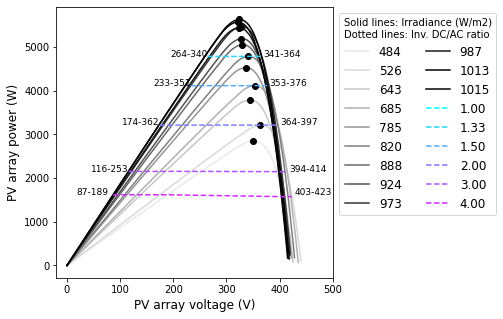

In [7]:
# print(combdf[['rda3.0_vl','Array Vmpp (V)','rda3.0_vh']])
### Plot P-V curves and clip levels
# For plotting purpose, sort the I-V curves according to the irradiance
combdf = combdf.sort_values('8157_S1POA (W/m2)')

## Import a color map
cm1 = plt.get_cmap('Greys')
fig,ax = plt.subplots(figsize=(6,4))
for i in combdf.index:
    idx = combdf.index.get_loc(i)
    # idx+2 because the last plots are invisible under the gradient color, idx+2 will skip the last colors
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array power (W)'].loc[i], 
             label='%d'%(combdf['8157_S1POA (W/m2)'].loc[i]),color=cm1((idx+2)/len(combdf)))
    plt.plot(combdf['Array Vmpp (V)'].loc[i],combdf['Array Pmpp (W)'].loc[i],'ok')
# plot the clipping lines 
cm2 = plt.get_cmap('cool')
for j in clpdf.index:
    idx = clpdf.index.get_loc(j)
    # idx+2 because the last plots are invisible under the gradient color, idx+2 will skip the last colors
    plt.plot(clpdf[['Vl1_clp','Vl2_clp','Vh1_clp','Vh2_clp']].loc[j].tolist(),
             np.array(clpdf[['Vl_pwr','Vh_pwr']].loc[j].tolist()).repeat(2),'--',color=cm2((idx)/len(clpdf)),
             label='%.2f'%(clpdf['DC/AC Ratio'].loc[j]))
plt.legend(loc='best',bbox_to_anchor=(1,1),
           fontsize=12,ncol=2,title='Solid lines: Irradiance (W/m2)\nDotted lines: Inv. DC/AC ratio')  
# Text on the plot
lbldf = clpdf[['Vl1_clp','Vl2_clp','Vh1_clp','Vh2_clp']].dropna(how='any')
for k in clpdf[['Vl1_clp','Vl2_clp','Vh1_clp','Vh2_clp']].dropna().index:
    plt.text(clpdf['Vl1_clp'].loc[k]-70,clpdf['Vl_pwr'].loc[k],'%d-%d'%(clpdf['Vl1_clp'].loc[k],clpdf['Vl2_clp'].loc[k]),size=9)
    # plt.text(clpdf['Vl2_clp'].loc[k],clpdf['Vl_pwr'].loc[k],'%d'%(clpdf['Vl2_clp'].loc[k]),size=10)
    # plt.text(clpdf['Vh1_clp'].loc[k],clpdf['Vl_pwr'].loc[k],'%d'%(clpdf['Vh1_clp'].loc[k]),size=10)
    plt.text(clpdf['Vh2_clp'].loc[k]+5,clpdf['Vl_pwr'].loc[k],'%d-%d'%(clpdf['Vh1_clp'].loc[k],clpdf['Vh2_clp'].loc[k]),size=9)
## Axis limits
plt.xlim([-20,500])
plt.xlabel('PV array voltage (V)',fontsize=12)
plt.ylabel('PV array power (W)',fontsize=12)
temp_name3 = '/ArrayCurves_clip_levels.png'
plt.subplots_adjust(left=0.15, right=0.79, top=0.99, bottom=0.05)        
plt.savefig(fold_loc+temp_name3,bbox_inches='tight',pad_inches=0.1, dpi=250)
plt.show()
# Round all decimals to two
clpdf = clpdf.round(2)
# Drop unnecessary columns
# clpdf.drop(['Vl_pwr','Vh_pwr'],axis=1,inplace=True)

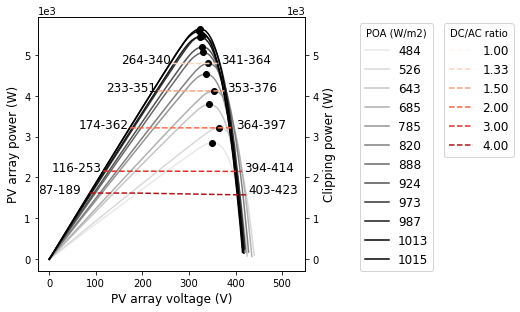

In [8]:
# print(combdf[['rda3.0_vl','Array Vmpp (V)','rda3.0_vh']])
### Plot P-V curves and clip levels
# For plotting purpose, sort the I-V curves according to the irradiance
combdf = combdf.sort_values('8157_S1POA (W/m2)')

## Import a color map
cm1 = plt.get_cmap('Greys')

fig,ax = plt.subplots(figsize=(6,4))
curs = []
for i in combdf.index:
    idx = combdf.index.get_loc(i)
    # idx+2 because the last plots are invisible under the gradient color, idx+2 will skip the last colors
    # plt.hold(1)
    ax.plot(combdf['Array voltage (V)'].loc[i],combdf['Array power (W)'].loc[i], 
             label='%d'%(combdf['8157_S1POA (W/m2)'].loc[i]),color=cm1((idx+2)/len(combdf)))
    ax.plot(combdf['Array Vmpp (V)'].loc[i],combdf['Array Pmpp (W)'].loc[i],'ok')
    # curs.append(a)
ax.ticklabel_format(style='sci', axis='y',scilimits=(0, 0))
ax.legend(loc=1,bbox_to_anchor=(1.5,1),fontsize=12,ncol=1,title='POA (W/m2)')
# Axis limits
ax.set_xlim([-25,550])
ax.set_xlabel('PV array voltage (V)',fontsize=12)
ax.set_ylabel('PV array power (W)',fontsize=12)

# Right y-plot: plot the clipping power lines lines 
cm2 = plt.get_cmap('Reds')
# clips = []
ymin, ymax = ax.get_ylim()
ax2 = ax.twinx()
clp_idx = clpdf.index
for j in clp_idx:
    idx = clpdf.index.get_loc(j)
    # idx+2 because the last plots are invisible under the gradient color, idx+2 will skip the last colors
    ax2.plot(clpdf[['Vl1_clp','Vl2_clp','Vh1_clp','Vh2_clp']].loc[j].tolist(),
             np.array(clpdf[['Vl_pwr','Vh_pwr']].loc[j].tolist()).repeat(2),'--',color=cm2((idx)/len(clpdf)),
             label='%.2f'%(clpdf['DC/AC Ratio'].loc[j]))
ax2.ticklabel_format(style='sci', axis='y',scilimits=(0, 0))
ax2.set_ylim([ymin,ymax])
ax2.set_ylabel('Clipping power (W)',fontsize=12)
ax2.legend(loc=1,bbox_to_anchor=(1.8,1),fontsize=12,ncol=1,title='DC/AC ratio')
# ax.vlines(153,0,ymax*0.9,colors='tab:blue') 
# # Text on the plot
lbldf = clpdf[['Vl1_clp','Vl2_clp','Vh1_clp','Vh2_clp']].dropna(how='any')
lbl_idx = clpdf[['Vl1_clp','Vl2_clp','Vh1_clp','Vh2_clp']].dropna().index
for k in lbl_idx:
    ax.text(clpdf['Vl1_clp'].loc[k]-110,clpdf['Vl_pwr'].loc[k],'%d-%d'%(clpdf['Vl1_clp'].loc[k],clpdf['Vl2_clp'].loc[k]),size=12)
    ax.text(clpdf['Vh2_clp'].loc[k]+5,clpdf['Vl_pwr'].loc[k],'%d-%d'%(clpdf['Vh1_clp'].loc[k],clpdf['Vh2_clp'].loc[k]),size=12)
temp_name3 = '/ArrayCurves_clip_levels4.png'
plt.subplots_adjust(left=0.08, right=0.70, top=0.97, bottom=0.09)        
plt.savefig(fold_loc+temp_name3,bbox_inches='tight',pad_inches=0.1, dpi=300)
plt.show()
# Round all decimals to two
clpdf = clpdf.round(2)
# Drop unnecessary columns
# clpdf.drop(['Vl_pwr','Vh_pwr'],axis=1,inplace=True)

In [9]:
print(np.mean(np.abs(combdf['8157_S1POA (W/m2)']-combdf['8157_S2POA (W/m2)'])))
print(combdf['8157_S1POA (W/m2)']-combdf['8157_S2POA (W/m2)'])


11.472757174291667
datetime
2019-01-29 16:17:17    22.600668
2019-01-29 08:57:17   -17.985039
2019-01-29 15:37:17    14.801846
2019-01-29 09:37:17   -16.075123
2019-01-29 14:57:17    15.597644
2019-01-29 10:17:17   -13.051090
2019-01-29 14:17:17     5.570587
2019-01-29 10:57:17    -9.708738
2019-01-29 13:37:17    13.687729
2019-01-29 11:37:17    -2.864873
2019-01-29 12:57:17     2.069075
2019-01-29 12:17:17    -3.660672
dtype: float64
